Code Lab 1: Skin Cancer MNIST
=========================

## The Problem

From ISIC 2018: Skin Lesion Analysis Website [https://challenge2018.isic-archive.com]

> Skin cancer is a major public health problem, with over 5,000,000 newly diagnosed cases in the United States every year. Melanoma is the deadliest form of skin cancer, responsible for an overwhelming majority of skin cancer deaths. In 2015, the global incidence of melanoma was estimated to be over 350,000 cases, with almost 60,000 deaths. Although the mortality is significant, when detected early, melanoma survival exceeds 95%.

![skin-cancer-cover](imgs/skin-mnist-cover.png "Examples of Skin Lesions")

## Imports

In [2]:
from __future__ import print_function, division
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import os
import pandas as pd
from IPython.display import display, HTML

Let's import Tensorflow now.  It is helpful after importing Tensorflow to check the version of the library installed since the API's are changing so quickly.  Several machines are now starting to use Tensorflow 2.0rc which has a very different interface from v1.* as well.  In preparation for TF 2.0, this tutorial will use the Eager Execution API, which is used by default in future version.

In [4]:
import tensorflow as tf
tf.enable_eager_execution()

tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
print('Tensorflow version: ',tf.__version__)
print('Is GPU available: %s' % str(tf.test.is_gpu_available()))
print('Is Eager Execution enabled?: %s' % str(tf.executing_eagerly()))

Tensorflow version:  1.13.1
Is GPU available: False
Is Eager Execution enabled?: True


## Dataset

### About HAM10000

In this exercise will will be using  HAM10000 ("Human Against Machine with 10000 training images") dataset which is a collection of "dermatoscopic images from different populations, acquired and stored by different modalities."[Kaggle](https://www.kaggle.com/kmader/skin-cancer-mnist-ham10000) This dataset has ~10K dermatoscopic images that have been reformatted to be similar to the famous Handwritten Digit or MNIST dataset (28 x 28 images centered on the subject).  This allows us to focus on setting up our environment and making sure we can get a model working on a more interesting, healthcare-related problem.

### Load the dataset

We will load both the included meta file as well as the image data (provided conveniently as a CSV file with one row per image.

In [5]:
IS_ONEPANEL = False
NEED_DOWNLOAD = False
if IS_ONEPANEL:
    DATA_DIR='/onepanel/input'
else:
    import os
    import load_data
#     DATA_DIR = '/storage/codelab1'
    DATA_DIR = 'data'
    if NEED_DOWNLOAD:
        if not os.path.exists(DATA_DIR):
            os.mkdir(DATA_DIR)
        FILELIST = ['HAM10000_metadata.csv','hmnist_28_28_RGB.csv']
        load_data.download_files(FILELIST,DATA_DIR)

In [6]:
meta_df = pd.read_csv(os.path.join(DATA_DIR,'HAM10000_metadata.csv'))
img_df = pd.read_csv(os.path.join(DATA_DIR,'hmnist_28_28_RGB.csv'))

We will split the `img_df` or image dataframe into an image numpy array (img_array) as well as a `lbl_array`, which contains the target classes.

In [7]:
img_array = img_df.values[:,:-1].reshape(-1,28,28,3)
lbl_array = img_df.values[:,-1:]

In [9]:
np.unique(lbl_array, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6]),
 array([ 327,  514, 1099,  115, 6705,  142, 1113]))

### Inspect the meta data

#### Lesions with multiple images

For each image we have a `lesion_id` as well as a an `image_id`.  We should note that there are in fact multiple images for the same lesion which we need to be mindful of as we construct our training and testing splits.

In [20]:
meta_df['sample_id'] = meta_df.index.values

In [21]:
meta_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,dupe,sample_id
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,True,0
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,True,1
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,True,2
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,True,3
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,True,4


Below, we count the occurrences of a lesion_id, accumulate the lesions ids with more than 1 image and then add a flag to our original meta_df to indicate whether the lesion has more than one image in the dataset.

In [22]:
def pretty_count_print(series):
    display(pd.DataFrame(series.value_counts()))

In [23]:
lesion_image_counts = pd.DataFrame( meta_df.groupby('lesion_id')['image_id'].count())
dupe_lesion_ids = list(lesion_image_counts[lesion_image_counts['image_id'] > 1].index.values)
meta_df['dupe'] = meta_df.apply(lambda row: row['lesion_id'] in dupe_lesion_ids, axis=1)
pretty_count_print(meta_df['dupe'])

,dupe
False,5514
True,4501


### Classes

The dataset contains 7 classes of lesions, a mixture of both benign and cancerous types.  The dataset is overweight to benign melanocytic nevi, a harmless mole.  However, there are over 2,000 examples of cancerous lesions to detect in this dataset.


| Id |Abbr | Name |
|---|---|---|
| 4 | nv | Melanocytic nevi |
| 6 | mel | Melanoma |
| 2 | bkl | Benign keratosis-like lesion |
| 1 | bcc | Basal cell carcinoma |
| 0 | akiec |  Actinic keratoses |
| 5 | vasc | Vascular lesions (angiomas, etc.) |
| 3 | df | Dermatofibroma |

In [24]:
class_list = ['akiec','bcc','bkl','df','mel','nv','vasc']
pretty_count_print(meta_df['dx'])

,dx
nv,6705
mel,1113
bkl,1099
bcc,514
akiec,327
vasc,142
df,115


Let's gather examples of each class to inspect visually.

In [25]:
example_list = {}
for cls in class_list:
    example_list[cls] = meta_df[meta_df['dx']==cls].index[0]
display(example_list)

{'akiec': 9687,
 'bcc': 2462,
 'bkl': 0,
 'df': 1095,
 'mel': 1211,
 'nv': 64,
 'vasc': 2320}

In [26]:
class_counts = np.array([327, 514, 1099,115,1113,6705,142],dtype=np.float32)
total_count = np.sum(class_counts)
weights = np.log(total_count * np.reciprocal(class_counts))
weights

array([3.421879 , 2.969616 , 2.2096834, 4.466907 , 2.1970248, 0.4012305,
       4.256012 ], dtype=float32)

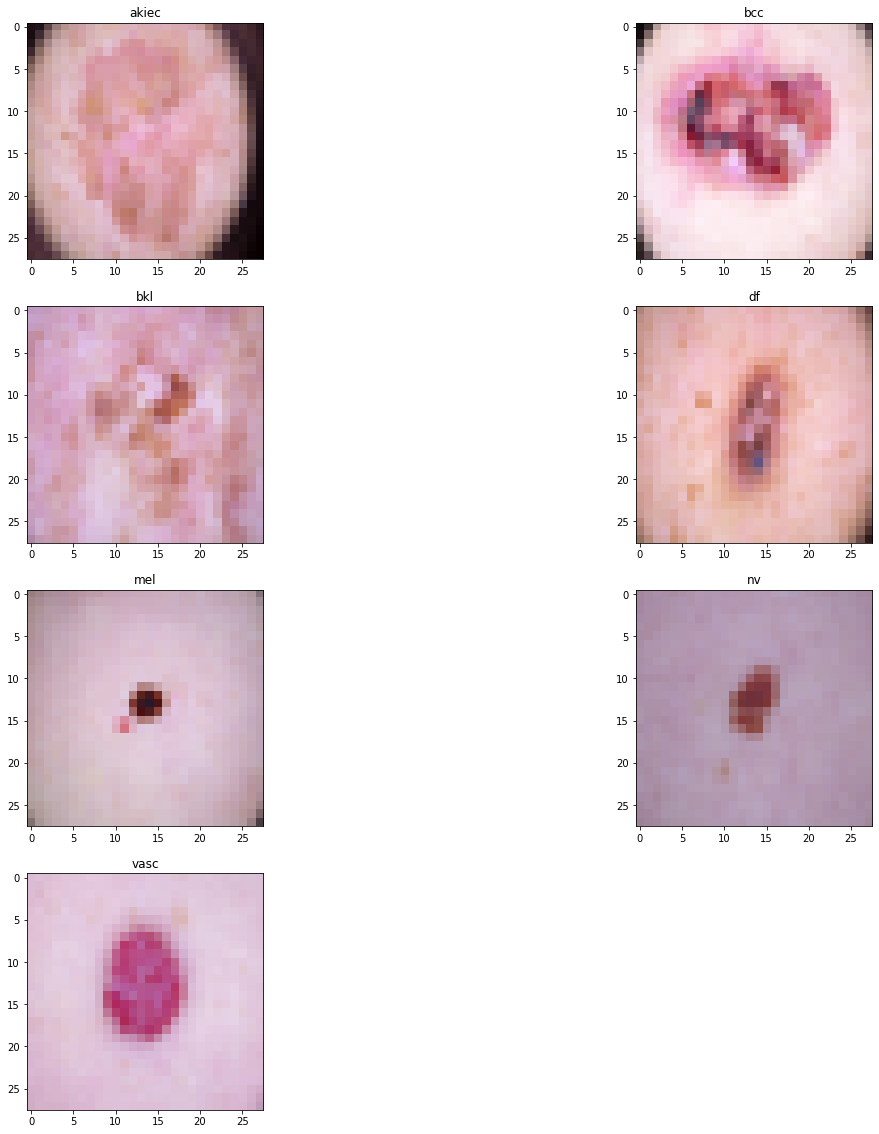

In [27]:
fig, ax = plt.subplots(4,2, figsize=(20,20))
fig.delaxes(ax[3,1]) # Delete the extra plot
for i, (key, value) in enumerate(example_list.items()):
    ax[i//2,i%2].title.set_text(key)
    ax[i//2,i%2].imshow(img_array[value])

### Prepare the data

For this step we will split the dataset into two parts: 1) a training set on which the parameters of the neural network model will be learning, 2) a held-out evaluation set that we will use to score the performance of our model.  Also we will preprocess our data and build functions for feeding our data to our model according to the Eager Execution API.

Also, given the imbalance of the dataset and the low resolution that we are using for demonstration purposes, we will confine ourselves to the binary classification problem of whether a lesion is a Nevus or not a Nevus.

In [28]:
lbl_array_bin = np.where(lbl_array == 4, 1 , 0 )
print("Fraction of Nevus present: %0.1f%%" % (np.mean(lbl_array_bin)*100.))

Fraction of Nevus present: 66.9%


#### Train/Test Split

Let us hold out 20% of the data that we have as a test set.  Since there are multiple images of the same lesion in the dataset, we need to make sure that only lesions with one image are included in the test set.  Otherwise information will leak from the training set to the dataset and invalidate our assumption that the model has never seen any of the test set during training. 

In [66]:
test_frac = 0.2
test_idx = list(meta_df[meta_df['dupe'] != True]
                .sample(int(test_frac * len(meta_df)),random_state=100)
                ['sample_id'])
test_mask = [ x in test_idx for x in range(len(meta_df))]
train_mask = [ not(x) for x in test_mask]

#### Preprocessing

Uniquely with toy datasets like this one, there is not much in the way of preprocessing to accomplish.  We will simply scale the 8-bit color values normalizing the per-channel mean and variance.

In [114]:
r_mean = np.mean(img_array[:,:,:,0])
g_mean = np.mean(img_array[:,:,:,1])
b_mean = np.mean(img_array[:,:,:,2])

r_std = np.std(img_array[:,:,:,0])
g_std = np.std(img_array[:,:,:,1])
b_std = np.std(img_array[:,:,:,2])

channel_mean = np.array([r_mean,g_mean, b_mean]).reshape(1,1,1,3)
channel_std = np.array([r_std,g_std, b_std]).reshape(1,1,1,3)
channel_mean, channel_std

img_array_norm = (img_array - channel_mean) / channel_std

In [115]:
train_x, train_y = img_array_norm[train_mask] / 255. , lbl_array_bin[train_mask]
test_x, test_y = img_array_norm[test_mask] / 255. , lbl_array_bin[test_mask]

In [116]:
print(train_x.shape, train_y.shape)
print(test_x.shape, test_y.shape)

(8012, 28, 28, 3) (8012, 1)
(2003, 28, 28, 3) (2003, 1)


In [119]:
np.mean(train_y), np.mean(test_y)

(0.6404143784323515, 0.7858212680978532)

#### Data Loading functions

These functions will load all of the data into the device memory in a format that the Eager Execution API works well when the data provided is via `tf.data.Dataset` which helps create an interable collection of tensors.

In [120]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_x,train_y))
train_dataset = train_dataset.shuffle(2000).batch(64)

In [121]:
test_dataset = tf.data.Dataset.from_tensor_slices((test_x,test_y))
test_dataset = test_dataset.batch(64)

## Model

Now we will construct the model using the modular Keras API, which will become the preferred method for building models in Tensorflow 2.0.  Specifically we will create a new model class that subclasses `tf.keras.Model` to incorporate our model design.  This helps with organizing the state of our graph as well as helps make models easier to replicate.

In [122]:
import tensorflow.keras as keras
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.initializers import he_normal
from tensorflow.keras.activations import sigmoid

### Design Parameters

There are a number of parameters required when building the model.  Below, we collect the parameters required in the model in the `model_design_params` nested dictionary.  The structure of the dictionary largely follows the design of the `VGG` like model that we will use to detect whether a lesion is a nevus or not.

In [123]:
model_design_params = {
     'block_1': {
         'conv2d': {
             'filters': 32,
             'kernel_size': 3,
             'strides': 1,
             'padding':'same',
             'activation':'relu',
          },
         'pooling': {
             'pool_size': 2,
             'strides': 2,
          },
         'dropout': 0.25,
     },
     'block_2': {
         'conv2d': {
             'filters': 64,
             'kernel_size': 3,
             'strides': 1,
             'padding':'same',
             'activation':'relu',
          },
         'pooling': {
             'pool_size': 2,
             'strides': 2,
          },
         'dropout': 0.25,
     },
     'head' : {
         'affine' : {
             'units': 256,
             'activation': 'relu',
         },
         'dropout': 0.5,
          'logits' : {
             'units': 1,
             'activation': None,
         },   
     }
}

### Model Definition

In [124]:
class NevusCNNClassifier(Model):
  def __init__(self,params):
    super(NevusCNNClassifier, self).__init__()
    
    # Block 1
    self.conv1_1 =  Conv2D(**params['block_1']['conv2d'])
    self.conv1_2 =  Conv2D(**params['block_1']['conv2d'])
    self.maxpool1 = MaxPooling2D(**params['block_1']['pooling'])
    self.dropout1 = Dropout(params['block_1']['dropout'])
    self.block1 =   Sequential([self.conv1_1,
                                self.conv1_2,
                                self.maxpool1,
                                self.dropout1]) # put it all together
    
    # Block 2
    self.conv2_1 =  Conv2D(**params['block_2']['conv2d'])
    self.conv2_2 =  Conv2D(**params['block_2']['conv2d'])
    self.maxpool2 = MaxPooling2D(**params['block_2']['pooling'])
    self.dropout2 = Dropout(params['block_2']['dropout'])
    self.block2 =   Sequential([self.conv2_1,
                                self.conv2_2,
                                self.maxpool2,
                                self.dropout2])
    
    # Head
    self.flatten =  Flatten()
    self.affine =   Dense(**params['head']['affine'])
    self.dropout3 = Dropout(params['head']['dropout'])
    self.logits =   Dense(**params['head']['logits'])
    self.head =     Sequential([self.flatten,
                                self.affine,
                                self.dropout3, 
                                self.logits])
    
  def call(self, x):
    x = self.block1(x)
    x = self.block2(x)
    logits = self.head(x)
    probability  = sigmoid(logits)
    return logits, probability

In [125]:
# Create an instance of the model
model = NevusCNNClassifier(model_design_params)

Now that we've constructed the models.  Let's inspect the models now.  Keras comes with two handy built-in features for inspecting models.  Specfically, `model.summary()` and `keras.utils.plot_model`.

In [126]:
tmp = NevusCNNClassifier(model_design_params)
tmp.build((1,28,28,3))
tmp.block1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_20 (Conv2D)           multiple                  896       
_________________________________________________________________
conv2d_21 (Conv2D)           multiple                  9248      
_________________________________________________________________
max_pooling2d_10 (MaxPooling multiple                  0         
_________________________________________________________________
dropout_15 (Dropout)         multiple                  0         
Total params: 10,144
Trainable params: 10,144
Non-trainable params: 0
_________________________________________________________________


In [127]:
tmp.block2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_22 (Conv2D)           multiple                  18496     
_________________________________________________________________
conv2d_23 (Conv2D)           multiple                  36928     
_________________________________________________________________
max_pooling2d_11 (MaxPooling multiple                  0         
_________________________________________________________________
dropout_16 (Dropout)         multiple                  0         
Total params: 55,424
Trainable params: 55,424
Non-trainable params: 0
_________________________________________________________________


In [128]:
tmp.head.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_5 (Flatten)          multiple                  0         
_________________________________________________________________
dense_10 (Dense)             multiple                  803072    
_________________________________________________________________
dropout_17 (Dropout)         multiple                  0         
_________________________________________________________________
dense_11 (Dense)             multiple                  257       
Total params: 803,329
Trainable params: 803,329
Non-trainable params: 0
_________________________________________________________________


## Train

TALK ABOUT TENSORBOARD AND ALL OF THE THINGS ESTIMATOR GIVES YOU FOR FREE

### Training Setup

In [129]:
LEARNING_RATE = 1.e-4
CLIPVALUE = 2.
EPOCHS = 10

#### Loss Function

In [130]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [131]:
optimizer = tf.train.AdamOptimizer(learning_rate=LEARNING_RATE)

#### Performance Metrics

In [132]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.BinaryAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.BinaryAccuracy(name='test_accuracy')

#### Training Step

In [133]:
def train_step(images, labels):
  with tf.GradientTape() as tape:
    logits, probability = model(images)
    loss = loss_object(labels, logits)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))

  train_loss(loss)
  train_accuracy(labels, probability)

In [134]:
for image, label in train_dataset.take(1):
    train_step(image,label)

#### Evaluation Step

In [135]:
def test_step(images, labels):
  logits, probability = model(images)
  t_loss = loss_object(labels, logits)

  test_loss(t_loss)
  test_accuracy(labels, probability)

#### Training Loop

In [138]:
for epoch in range(EPOCHS):
  for images, labels in train_dataset:
    train_step(images, labels)

  for test_images, test_labels in test_dataset:
    test_step(test_images, test_labels)

  template = 'Epoch {}, Loss: {}, Accuracy: {}, Test Loss: {}, Test Accuracy: {}'
  print(template.format(epoch+1,
                        train_loss.result(),
                        train_accuracy.result()*100,
                        test_loss.result(),
                        test_accuracy.result()*100))

  # Reset the metrics for the next epoch
  train_loss.reset_states()
  train_accuracy.reset_states()
  test_loss.reset_states()
  test_accuracy.reset_states()

KeyboardInterrupt: 

## Evaluation

### Score the Model

In [ ]:
eval_results = ham_classifier.evaluate(input_fn=test_input_fn)
print(eval_results)

### Inspect Predictions

### Inspect feature vector

In [ ]:
'a'